# Import Modules

In [1]:
import importlib
import os
import sys

import joblib
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
os.chdir("../")
sys.path.insert(0, os.getcwd())

In [3]:
from morai.experience import charters
from morai.forecast import metrics, models, preprocessors
from morai.utils import custom_logger, helpers

In [4]:
logger = custom_logger.setup_logging(__name__)

In [5]:
# update log level if wanting more logging
custom_logger.set_log_level("INFO")

In [6]:
pd.options.display.float_format = "{:,.2f}".format

# Data

In [7]:
pl_parquet_path = r"files\dataset\mortality_grouped.parquet"

In [8]:
# reading in the dataset
# `enable_string_cache` helps with categorical type values
# casting columns to categorical (shouldn't need to do this, but it was changed in aggregation)
pl.enable_string_cache()
lzdf = pl.scan_parquet(
    pl_parquet_path,
).cast(
    {
        "sex": pl.Categorical,
        "smoker_status": pl.Categorical,
    }
)

In [9]:
initial_row_count = lzdf.select(pl.len()).collect().item()
print(
    f"row count: {initial_row_count} \n"
    f"exposures: {lzdf.select([pl.col('amount_exposed').sum()]).collect()[0,0]}"
)

row count: 1793414 
exposures: 9882883284164.027


In [10]:
grouped_df = lzdf.collect()

In [11]:
grouped_df = grouped_df.to_pandas()

# Functions

In [12]:
def get_importance(features, values):
    importance = pd.DataFrame({"feature": features, "importance": values})
    importance = importance.sort_values(by="importance", ascending=False)
    return importance

In [13]:
from sklearn.feature_selection import RFECV


class RFECV_with_weights(RFECV):
    def fit(self, X, y, sample_weight=None, **fit_params):
        """Fit the RFECV model with the ability to use sample weights."""
        # Store the sample weights as an attribute
        self.sample_weight_ = sample_weight
        return super(RFECV_with_weights, self).fit(X, y, **fit_params)

    def _fit_and_score_estimator(self, estimator, X, y, train, test, support_mask):
        """Customize to use sample weights in fitting the estimator."""
        if self.sample_weight_ is None:
            return super()._fit_and_score_estimator(
                estimator, X, y, train, test, support_mask
            )
        else:
            return super()._fit_and_score_estimator(
                estimator,
                X,
                y,
                train,
                test,
                support_mask,
                sample_weight=self.sample_weight_[train],
            )

# Preparing Data

## Filter

In [14]:
model_data = grouped_df[
    (grouped_df["attained_age"] >= 50)
    & (grouped_df["attained_age"] <= 95)
    & (grouped_df["issue_age"] >= 30)
    & (grouped_df["issue_age"] <= 80)
].copy()
model_data = model_data.reset_index(drop=True)
model_data["qx_log_raw"] = np.log(model_data["qx_raw"] + 1)

In [15]:
del grouped_df

## Calculated Fields

In [16]:
model_data["capped_duration"] = model_data["duration"].clip(upper=26)

## Feature Dictionary

In [25]:
feature_dict = {
    "target": ["qx_raw"],
    "weight": ["amount_exposed"],
    "passthrough": ["attained_age", "duration", "observation_year"],
    "ordinal": [
        "sex",
        "slct_ult_ind",
        "smoker_status",
    ],
    "ohe": [
        "face_amount_band",
        "insurance_plan",
        "preferred_class",
    ],
    "nominal": [],
}

feature_dict_vbt = {
    "target": ["qx_raw"],
    "weight": ["amount_exposed"],
    "passthrough": ["attained_age", "capped_duration"],
    "ordinal": [
        "sex",
        "smoker_status",
    ],
    "ohe": [],
    "nominal": [],
}

feature_dict_all = {
    "target": ["qx_raw"],
    "weight": ["amount_exposed"],
    "passthrough": [
        "attained_age",
        "duration",
        "issue_age",
        "issue_year",
        "observation_year",
    ],
    "ordinal": [
        "sex",
        "slct_ult_ind",
        "smoker_status",
    ],
    "ohe": [
        "face_amount_band",
        "insurance_plan",
        "number_of_pfd_classes",
        "preferred_class",
        "soa_post_lvl_ind",
    ],
    "nominal": [],
}

## Data Preprocess

In [26]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict=feature_dict,
    standardize=False,
    preset="tree",
)

 2024-06-18 23:45:51 | morai.forecast.preprocessors | WARNING  | ['slct_ult_ind'] not in the model_data 
 2024-06-18 23:45:51 | morai.forecast.preprocessors | INFO     | using 'tree' preset which doesn't need to use 'nominal' or 'ohe' and instead uses 'ordinal' 
 2024-06-18 23:45:51 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-06-18 23:45:51 | morai.forecast.preprocessors | INFO     | model weights: ['amount_exposed'] 
 2024-06-18 23:45:51 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['attained_age', 'observation_year', 'duration'] 
 2024-06-18 23:45:51 | morai.forecast.preprocessors | INFO     | ordinal - ordinal encoded: ['smoker_status', 'sex', 'face_amount_band', 'preferred_class', 'insurance_plan'] 


In [27]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=0, test_size=0.2
)

# Model

In [28]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=5,
    random_state=42,
)

# Feature Selection

## Feature Importance

In [29]:
model.fit(X_train, y_train, sample_weight=weights_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5,
                      random_state=42)

In [32]:
importance = get_importance(features=X.columns, values=model.feature_importances_)

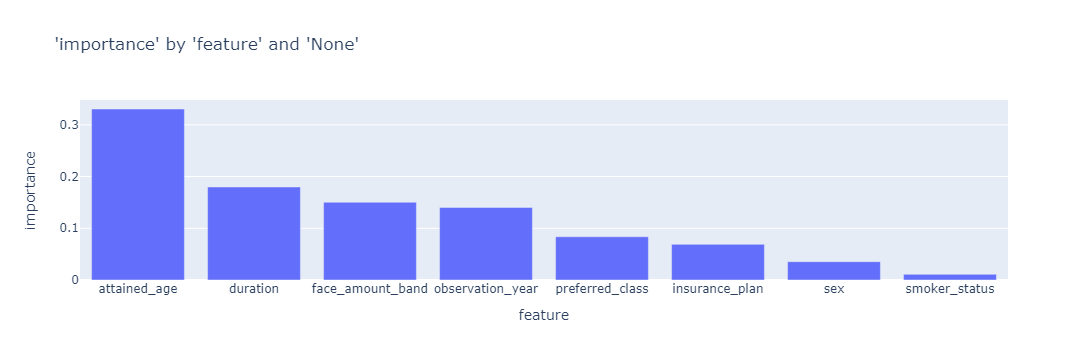

In [33]:
charters.chart(
    df=importance, x_axis="feature", y_axis="importance", type="bar", y_sort=True
)

## PDP Importance

Although not calculated PDP importance is calculate by the variability in the PDP plot. For numerical features it would be the standard deviation while for categorical it would be the min/max range.

## Permutation Importance

Permutation importance takes a feature and scrambles the data and then scores the model from the new data. If the score of the model differs significantly the feature is assumed to be important.

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
perm_imp = permutation_importance(model, X=X_train, y=y_train, random_state=0)
perm_imp = pd.DataFrame(
    {"feature": X_train.columns, "importance": perm_imp.importances_mean}
)

In [ ]:
charters.chart(
    df=perm_imp, x_axis="feature", y_axis="importance", type="bar", y_sort=True
)

## Select From Model

Select from Model (SFM) will provide the features from the model that are important enough. If the threshold is None then the features will be greater than the mean or 1e-5 if a parameter penalty is set.

In [98]:
from sklearn.feature_selection import SelectFromModel

trans = SelectFromModel(estimator=model, prefit=True)

In [99]:
X_train.columns[trans.get_support()]

Index(['attained_age', 'observation_year', 'duration', 'face_amount_band'], dtype='object')

## RFE

Recursive Feature Elimination (RFE) will identify the features with the least importance and eliminate from model. It will do this until the desired number of features is reached. The desired amount of features is 50% of total amount of features if not provided.

In [ ]:
from sklearn.feature_selection import RFE

trans = RFE(estimator=model)
trans.fit(X_train, y_train, sample_weight=weights_train)
x_trans = trans.transform(X_train)

In [111]:
trans.feature_names_in_

array(['attained_age', 'observation_year', 'duration', 'sex',
       'smoker_status', 'insurance_plan', 'preferred_class',
       'number_of_pfd_classes', 'face_amount_band'], dtype=object)

In [112]:
trans.get_feature_names_out()

array(['attained_age', 'observation_year', 'duration', 'face_amount_band'],
      dtype=object)

## RFECV

Recursive Feature Elimination Cross Validation (RFECV) is similar to RFE and will identify the features with the least importance and eliminate from model. The difference is that the CV will identify the number of features to use

In [ ]:
trans = RFECV_with_weights(estimator=model)
trans.fit(X_train, y_train, sample_weight=weights_train)
x_trans = trans.transform(X_train)

In [114]:
trans.feature_names_in_

array(['attained_age', 'observation_year', 'duration', 'sex',
       'smoker_status', 'insurance_plan', 'preferred_class',
       'number_of_pfd_classes', 'face_amount_band'], dtype=object)

In [115]:
trans.get_feature_names_out()

array(['attained_age'], dtype=object)

## Select KBest

Select KBest is selecting the best features given a statistical method and is not dependent on a model

In [116]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression

trans = SelectKBest(score_func=f_regression, k=5)
trans.fit(X_train, y_train)
X_train.columns[trans.get_support()]

Index(['attained_age', 'duration', 'smoker_status', 'preferred_class',
       'face_amount_band'],
      dtype='object')

## Boruta

In [79]:
from boruta import BorutaPy

In [91]:
# boruta hasn't been updated in a while
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

In [92]:
trans = BorutaPy(estimator=model, n_estimators="auto")

In [ ]:
trans.fit(X_train.to_numpy(), y_train.to_numpy())

In [104]:
X_train.columns[trans.get_support()]

Index(['attained_age', 'observation_year', 'duration', 'face_amount_band'], dtype='object')

In [109]:
feature_ranking = pd.DataFrame({"feature": X_train.columns, "ranking": trans.ranking_})
feature_ranking

,feature,ranking
0,attained_age,1
1,observation_year,1
2,duration,1
3,sex,4
4,smoker_status,6
5,insurance_plan,2
6,preferred_class,3
7,number_of_pfd_classes,5
8,face_amount_band,1


# Feature Interactions

The H-statistic compares the strength of interaction of features in the model.

In [34]:
from sklearn.inspection import h_statistic

In [37]:
h_stats = h_statistic(model, X=X_train, features=X_train.columns, random_state=0)

In [44]:
h_df = pd.DataFrame(
    {
        "feature_1": [pair[0] for pair in h_stats["feature_pairs"]],
        "feature_2": [pair[1] for pair in h_stats["feature_pairs"]],
        "pair": [str(pair) for pair in h_stats["feature_pairs"]],
        "h2": np.array(h_stats["h_squared_pairwise"]).flatten(),
        "unnormalized_h": np.sqrt(np.array(h_stats["numerator_pairwise"]).flatten()),
    }
).sort_values(by="h2", ascending=False)

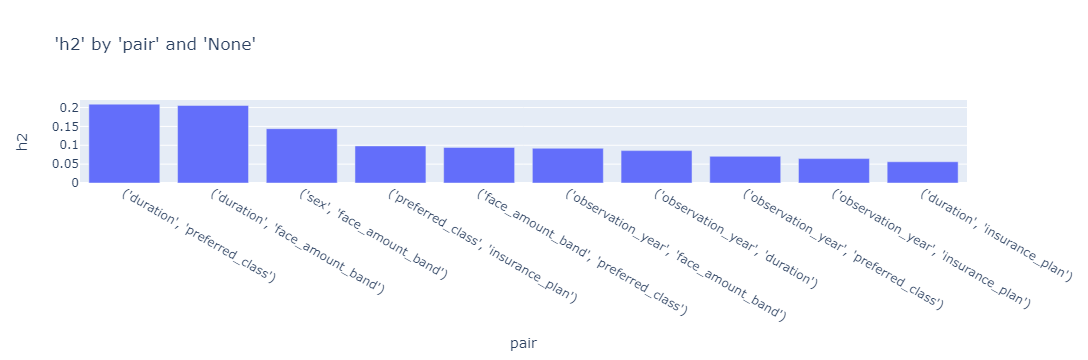

In [45]:
charters.chart(df=h_df.head(10), x_axis="pair", y_axis="h2", type="bar", y_sort=True)

In [ ]:
charters.chart(
    df=h_df.head(10), x_axis="pair", y_axis="unnormalized_h", type="bar", y_sort=True
)

 2024-06-19 00:45:48 | morai.experience.charters | INFO     | Model: [RandomForestRegressor] for partial dependence plot. 
 2024-06-19 00:45:48 | morai.experience.charters | INFO     | Weights: [amount_exposed] 
 2024-06-19 00:45:48 | morai.experience.charters | INFO     | x_axis: [face_amount_band] type: [passthrough] 
 2024-06-19 00:45:48 | morai.experience.charters | INFO     | Line feature: [sex] type: [ordinal] 
 2024-06-19 00:45:48 | morai.experience.charters | INFO     | Creating 22 predictions. 
 2024-06-19 00:45:48 | morai.experience.charters | INFO     | Running '16' cores for parrallel processing. 


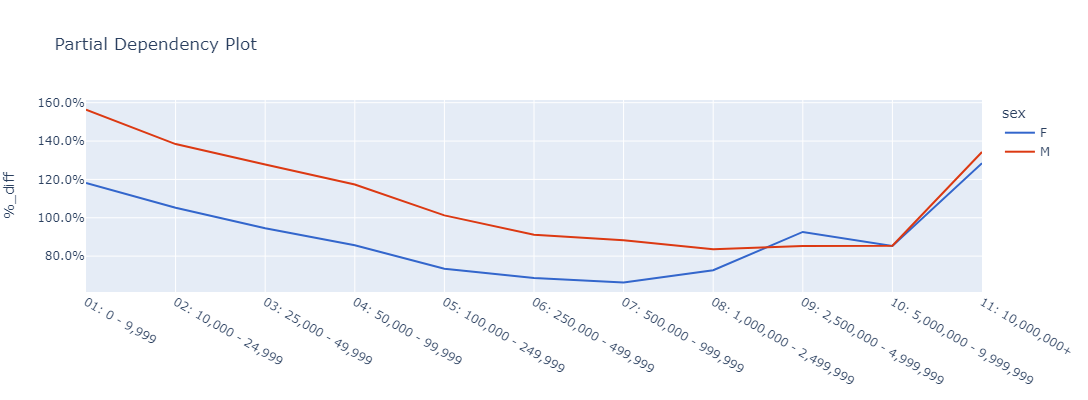

In [57]:
charters.pdp(
    model=model,
    df=md_encoded,
    x_axis="face_amount_band",
    line_color="sex",
    weight="amount_exposed",
    mapping=mapping,
    display=True,
    n_jobs=10,
)

# Feature Engineering

In [82]:
model_data["duration_sqrd"] = model_data["duration"] ** 2
model_data["duration_sqrt"] = model_data["duration"] ** 0.5
model_data["attained_age_sqrd"] = model_data["attained_age"] ** 2
model_data["attained_age_sqrt"] = model_data["attained_age"] ** 0.5
model_data["attained_age_exp"] = np.exp(model_data["attained_age"])

 2024-06-19 01:17:51 | morai.experience.charters | INFO     | Creating '8' target plots. 


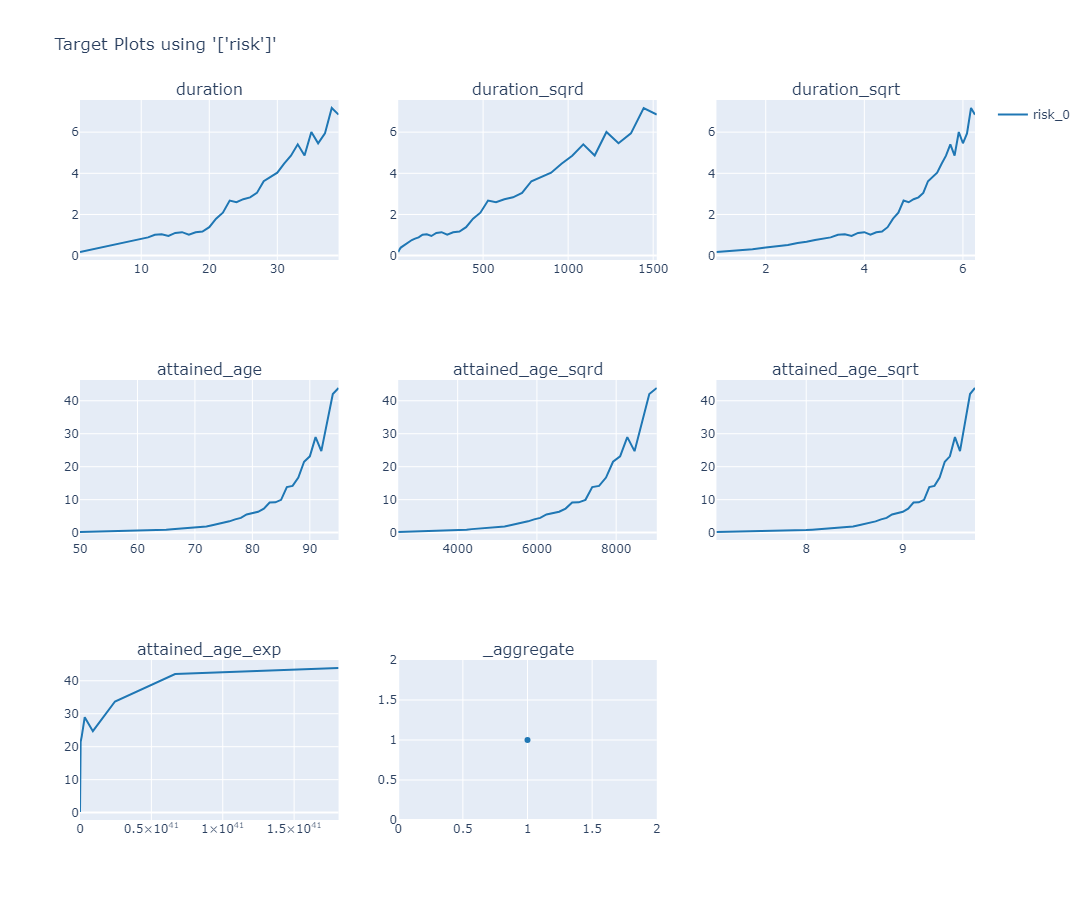

In [83]:
charters.target(
    df=model_data,
    target="risk",
    cols=3,
    features=[
        "duration",
        "duration_sqrd",
        "duration_sqrt",
        "attained_age",
        "attained_age_sqrd",
        "attained_age_sqrt",
        "attained_age_exp",
    ],
    numerator=["death_claim_amount"],
    denominator=["amount_exposed"],
).show()

 2024-06-19 01:20:27 | morai.experience.charters | INFO     | Calculating ratio using [death_claim_amount] and [amount_exposed] 


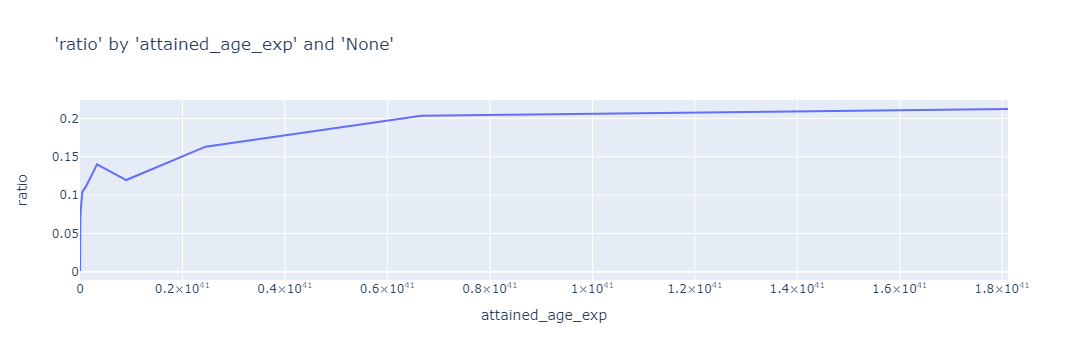

In [87]:
charters.chart(
    df=model_data,
    x_axis="attained_age_exp",
    y_axis="ratio",
    color=None,
    type="line",
    numerator="death_claim_amount",
    denominator="amount_exposed",
    y_log=False,
)